In [2]:
import gooseberry as gs 

import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from matplotlib.patches import Ellipse
import numpy as np 

import jax 
import jax.numpy as jnp
from functools import partial 

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

In [3]:
def balanced_weights(in_dim, hidden_dim, out_dim, c):
    w1 = np.eye(hidden_dim, in_dim) * np.sqrt(c + 1)
    w2 = np.eye(out_dim, hidden_dim)

    return w1, w2

In [4]:
def logger(params, X, Y, f):
    w2w1 = params["network"]["layer-1"]["w"][0] @ params["network"]["layer-0"]["w"][0]
    Y_hat = params["network"]["layer-1"]["w"][0] @ f(params["network"]["layer-0"]["w"][0] @ X.T)
    loss = 0.5 * np.mean(np.sum((Y_hat.T - Y)**2, axis=1))
    return w2w1, loss

In [7]:
np.random.seed(2)

in_dim = 5
hidden_dim = 10
out_dim = 6

batch_size = 25
learning_rate = 0.05
training_steps = 6000

initial_weight_scale = 0.0001

num_tasks = 3

training_datas = []
for i in range(num_tasks):
    # init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, 0.3)
    init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, c=0.03)
    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    training_datas.append(training_data)

losses = [[] for _ in range(num_tasks)]

logs = jax.jit(partial(logger, f=gs.nonlinearities.Identity()))

ws = []
analyticals = []
for i, training_data in enumerate(training_datas):
    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    if i == 0:
        # init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_weight_scale)
        init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, c=0.03)
    else:
        init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])
    
    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)
    
    for training_step in range(training_steps):
        for j, data in enumerate(training_datas):
            X, Y = data(None)
            w2w1, loss = logs(params, X, Y)
            losses[j].append(loss)
        ws.append(w2w1)
        
        state, params, loss = trainer(state, params)
    
    X, Y = training_data(None)
    analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    analyticals.append(np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)]))

ws = np.asarray(ws)
losses = np.asarray(losses)
analyticals = np.asarray(analyticals)

In [6]:
losses

array([[3.1804178 , 2.6560364 , 2.271782  , ..., 0.553936  , 0.553936  ,
        0.553936  ],
       [2.8283517 , 2.3501074 , 2.0028741 , ..., 0.47651434, 0.47651434,
        0.47651434],
       [2.876466  , 2.3957942 , 2.0463033 , ..., 0.36277544, 0.36277544,
        0.36277544]], dtype=float32)

In [8]:
ws

array([[[ 1.01488912e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.01488912e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.01488912e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.01488912e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.01488912e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]],

       [[ 9.13397312e-01,  5.98811358e-03, -1.78855732e-02,
          1.34249516e-02, -7.08725210e-03],
        [-6.96608052e-03,  9.12093282e-01, -5.79824112e-03,
          1.88253378e-03, -7.35831261e-03],
        [ 1.50000099e-02,  1.99879240e-03,  9.19658005e-01,
          2.06600269e-03, -1.35891791e-02],
        [ 1.21803675e-03,  8.47943127e-03,  2.03630561e-03,
  

In [9]:
analyticals

array([[[[ 1.01488917e+00,  1.13303479e-08, -2.02248281e-08,
          -2.91673977e-08, -8.99703232e-10],
         [ 1.13320250e-08,  1.01488915e+00, -9.11185200e-09,
           2.97594721e-08,  1.17559092e-08],
         [-2.02243008e-08, -9.11202859e-09,  1.01488915e+00,
           2.06798239e-09,  2.09607692e-08],
         [-2.91655731e-08,  2.97591879e-08,  2.06788226e-09,
           1.01488916e+00, -5.18350103e-09],
         [-8.99799801e-10,  1.17565565e-08,  2.09607241e-08,
          -5.18460029e-09,  1.01488919e+00],
         [-4.36223743e-09, -2.51518312e-08,  1.61598874e-08,
           5.66747648e-09,  4.20455586e-09]],

        [[ 9.20496602e-01,  5.74679000e-03, -1.70173542e-02,
           1.25226918e-02, -6.93026057e-03],
         [-6.63081289e-03,  9.19247754e-01, -5.46625046e-03,
           1.57296001e-03, -6.56707022e-03],
         [ 1.44339695e-02,  1.98206316e-03,  9.26220929e-01,
           1.84996428e-03, -1.27750935e-02],
         [ 8.46853337e-04,  7.87820817e-03, 

ValueError: x and y must have same first dimension, but have shapes (6000,) and (1,)

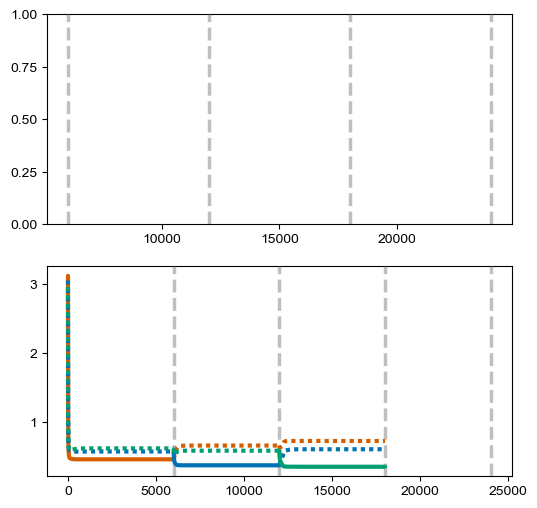

In [10]:
last_task_lim = training_steps // 2
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
blind_colours = BlindColours().get_colours()

for i, (colour, rng) in enumerate(zip(blind_colours, [training_steps * j for j in range(1, 4)] + [training_steps * 4 - 1])):
    start = rng - training_steps
    end = rng
    #axs[0].plot(range(start, end), ws[start:end].reshape(-1, in_dim * out_dim), c=colour)
    for j in range(2):
        axs[j].axvline(end, linestyle="--", c="grey", alpha=0.5, lw=2.5, zorder=3)
        
    for j, (colour, loss) in enumerate(zip(blind_colours, losses)):
        if i != j:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., linestyle=(0, (1, 1)), zorder=4)
        else:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., zorder=4)
axs[0].plot(analyticals.reshape(-1, in_dim * out_dim)[:-last_task_lim], c="k", alpha=0.7, linestyle=(0, (1, 2)))

for i in range(2):
    axs[i].set_xlim(0., end-last_task_lim)

axs[0].set_ylim(-.25, .31)
axs[0].set_yticks([-.2, 0., .2])
axs[0].set_xticks([])

axs[1].set_ylim(0.3, .68)
#axs[1].set_yticks([0., 5.])
axs[1].set_xticks(range(0, training_steps*4, training_steps))

for i, x_pos in enumerate([0.18, 0.40, 0.62]):
    fig.text(x_pos, 0.88, f"Task {i+1}", fontsize=18, c="k")
fig.text(0.83, 0.88, "$...$", fontsize=18, c="k")

axs[0].set_ylabel("$W_2W_1(t)$", fontsize=15)
axs[1].set_ylabel("Loss", labelpad=20.)
axs[1].set_xlabel("Training Steps")

sns.despine()
fig.savefig("./figures/figure-5_a.svg")

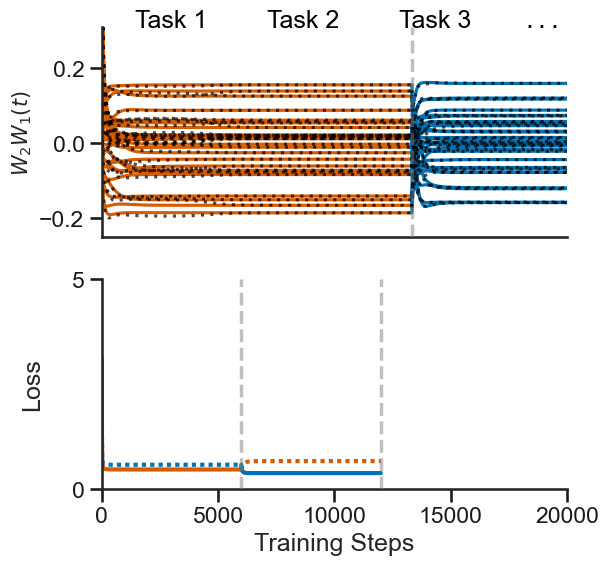

In [14]:
last_task_lim = training_steps // 2
fig, axs = plt.subplots(2, 1, figsize=(6,6))
blind_colours = BlindColours().get_colours()

for i, (colour, rng) in enumerate(zip(blind_colours, [training_steps * j for j in range(1, num_tasks)] + [training_steps * num_tasks - 1])):
    start = rng - training_steps
    end = rng
    axs[0].plot(range(start, end), ws[start:end].reshape(-1, in_dim * out_dim), c=colour)
    for j in range(2):
        axs[j].axvline(end, linestyle="--", c="grey", alpha=0.5, lw=2.5, zorder=3)
        
    for j, (colour, loss) in enumerate(zip(blind_colours, losses)):
        if i != j:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., linestyle=(0, (1, 1)), zorder=num_tasks)
        else:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., zorder=num_tasks)
axs[0].plot(analyticals.reshape(-1, in_dim * out_dim)[:-last_task_lim], c="k", alpha=0.7, linestyle=(0, (1, 2)))

for i in range(2):
    axs[i].set_xlim(0., end-last_task_lim)

axs[0].set_ylim(-.25, .31)
axs[0].set_yticks([-.2, 0., .2])
axs[0].set_xticks([])

axs[1].set_ylim(0.3, .68)
axs[1].set_yticks([0., 5.])
axs[1].set_xticks(range(0, 20001, 5000))

for i, x_pos in enumerate([0.18, 0.40, 0.62]):
    fig.text(x_pos, 0.88, f"Task {i+1}", fontsize=18, c="k")
fig.text(0.83, 0.88, "$...$", fontsize=18, c="k")

axs[0].set_ylabel("$W_2W_1(t)$", fontsize=15)
axs[1].set_ylabel("Loss", labelpad=20.)
axs[1].set_xlabel("Training Steps")

sns.despine()
fig.savefig("./figures/figure-5_a.svg")


ValueError: x and y must have same first dimension, but have shapes (6000,) and (0, 30)

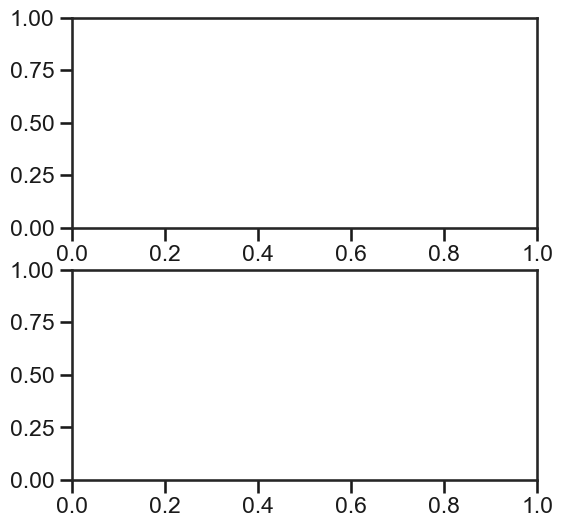

In [18]:
last_task_lim = training_steps // 2
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
blind_colours = BlindColours().get_colours()

task_to_plot = 0  # Choose the task you want to plot (0-indexed)

colour = blind_colours[task_to_plot]
rng = training_steps * (task_to_plot + 1) - 1
start = rng - training_steps
end = rng

axs[0].plot(range(start, end), ws[start:end].reshape(-1, in_dim * out_dim), c=colour)

if start >= last_task_lim:
    axs[0].plot(analyticals[start - last_task_lim:end - last_task_lim].reshape(-1, in_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))

for j in range(2):
    axs[j].axvline(end, linestyle="--", c="grey", alpha=0.5, lw=2.5, zorder=3)
    axs[j].set_xlim(0., end - last_task_lim)

loss = losses[task_to_plot]
axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., zorder=num_tasks)
axs[1].set_ylim(0.3, .68)
axs[1].set_xticks(range(0, 20001, 5000))
axs[1].set_ylabel("Loss", labelpad=20.)
axs[1].set_xlabel("Training Steps")

fig.text(0.18, 0.88, f"Task {task_to_plot + 1}", fontsize=18, c="k")
axs[0].set_ylabel("$W_2W_1(t)$", fontsize=15)

sns.despine()
fig.savefig("./figures/figure-5_a.svg")

In [ ]:
#i would like to do a plot of just one task to show how it evolves




In [ ]:
#i would also like to implement the analytical solution

In [ ]:
#i would also like to 

In [22]:
losses[-1]

array([3.359298  , 2.8557293 , 2.4843233 , ..., 0.40099937, 0.40099937,
       0.40099937], dtype=float32)